# Customized Mask-RCNN Model for Burned Area Segmentation

This model is an adaptation original Fast R-CNN torch model, with modified head to do Mask R-CNN for image segmentation. The backbone is ResNet50.

## 📌 Notebook Structure:

1. **Requirements and Imports**: Setting up the environment.
2. **Model Definition**: Construct model.
3. **Dataset Definition**: Preprocessing and loading the data.
4. **Training Function**: Implementation of the training loop.
5. **Validation Function**: Checking model performance on unseen data.
6. **Read Data from Google Drive**: Get data from Google Drive.
7. **Training Configs and Hyperparameters**: Setting up parameters for optimal training.
8. **Training**: Initiating the model training process.
9. **Validation and Testing**: Evaluating model performance.
10. **Visualize Results**: Displaying segmentation results visually.

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/group_by_aspect_ratio.py
!wget https://raw.githubusercontent.com/pytorch/vision/v0.15.2/references/detection/presets.py
!pip install -q numpy
!pip install -q torch torchvision
!pip install -q PILlow
!pip install -q tqdm
!pip install -q torchinfo
!pip install -q thop
!pip install -q opencv-python

In [4]:
### REQUIREMENTS
from pathlib import Path
import numpy as np
import torch
from PIL import Image
import torchvision
from multiprocessing import cpu_count
from torchinfo import summary
from tqdm import tqdm
import cv2
import random
from thop import profile
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms.functional as F
from matplotlib import pyplot as plt

import transforms as T
import utils
import engine

In [5]:
### MODEL
def get_model_instance_segmentation(num_classes, pre_trained=True):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT" if pre_trained else None)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [6]:
### DATASET

class BurnedAreaDataset(torch.utils.data.Dataset):
    def __init__(self, images_src, masks_src, transforms):

        self.transforms = transforms

        imgs = list(Path(images_src).glob("**/*.jpeg"))
        masks = list(Path(masks_src).glob("**/*.jpeg"))

        imgs = {img.stem: img for img in imgs}
        self.data = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]

    def __getitem__(self, idx):
        # load images and masks
        img_path = str(self.data[idx][0])
        mask_path = str(self.data[idx][1])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # normalize mask to 0 and 1
        mask = np.array(mask)
        mask_binary = np.where(mask > 127, 1, 0)
        mask = mask_binary

        # Extract unique values (colors) from the mask. Each unique value (except 0) corresponds to an instance.
        obj_ids = np.unique(mask_binary)

        # Remove the background (which is represented by a value of 0).
        obj_ids = obj_ids[1:]

        # Create binary masks for each individual instance.
        masks = mask == obj_ids[:, None, None]

        # Determine bounding boxes around each instance.
        num_objs = len(obj_ids)

        # in sementic segmentation, num_objs should always be 1

        if num_objs == 0:  # Handle images with no objects

            target = {
                "boxes": torch.empty((0, 4), dtype=torch.float32),
                "labels": torch.empty((0,), dtype=torch.int64),
                "masks": torch.empty((1, mask.shape[0], mask.shape[1]), dtype=torch.uint8),
                "image_id": torch.tensor([idx]),
                "area": torch.empty((10,), dtype=torch.float32),
                "iscrowd": torch.empty((0,), dtype=torch.int64),
            }

            # If any transformations are provided, apply them to the image and target.
            if self.transforms is not None:
                img, target = self.transforms(img, target)

                return img, target

        boxes = []
        for i in range(num_objs):
            # Get the bbox
            pos = np.nonzero(masks[i])

            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            boxes.append([xmin, ymin, xmax, ymax])

        # Convert bounding boxes into a torch.Tensor for consistency with the deep learning framework.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        # Compute the area of the bounding boxes. This can be used by some models to handle scale.
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # 'iscrowd' is a binary flag indicating whether the instance represents a crowd of objects or a single object.
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Construct the target dictionary.
        target = {
            "boxes": boxes,     # Bounding boxes
            "labels": labels,      # Class labels
            "masks": masks,       # Instance masks
            "image_id": image_id,  # Image ID
            "area": area,          # Area of bounding boxes
            "iscrowd": iscrowd,    # Crowd flag
        }

        # If any transformations are provided, apply them to the image and target.
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.data)


In [7]:
### TRAIN LOOP
def train(
    model,
    num_epochs,
    patience,
    train_dataloader,
    valid_dataloader,
    save_path,
    optimizer,
    scheduler,
    device,
):

    model.to(device)

    num_batch = len(train_dataloader)

    best_loss = 999.0
    best_acc = 0
    num_stop = 0
    best_mAP = 0
    num_stop = 0

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        engine.train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()

        # evaluate on the test dataset
        coco_evaluator = engine.evaluate(model, valid_dataloader, device=device)
        mAP50 = coco_evaluator.coco_eval["segm"].stats[1]

        if mAP50 > best_mAP:
            best_mAP = mAP50
            torch.save(model.state_dict(), save_path + "/best_model.pth")
            num_stop = 0
        else:
            num_stop += 1

        if num_stop > patience:
            print("Early stopping!")
            break

    # save model
    torch.save(model.state_dict(), save_path + "/last_model.pth")

    print("Training finished!")

In [8]:
### VAL LOOP

def validate_model(model, images_src, masks_src, device):

    imgs = list(Path(images_src).glob("**/*.jpeg"))
    masks = list(Path(masks_src).glob("**/*.jpeg"))

    imgs = {img.stem: img for img in imgs}
    data = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]


    model.eval()
    model.to(device)

    running_loss = 0.0

    running_f1 = 0.0
    running_iou = 0.0
    running_mcc = 0.0

    accuracy = {}

    n = 0

    with torch.no_grad():

        for image_path, mask_path in tqdm(data):
            image_path = str(image_path)
            mask_path = str(mask_path)

            image = read_image(image_path)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype(np.uint8)

            if mask.sum == 0:
                continue

            n += 1

            x = F.convert_image_dtype(image, dtype=torch.float)
            x = x[:3].to(device)
            outputs = model([x])
            outputs_0 = outputs[0]

            pred_masks = (outputs_0["masks"] > 0.5).squeeze(1).byte()
            combined_pred_mask = torch.clamp(pred_masks.sum(dim=0), 0, 1).cpu()
            combined_pred_mask = combined_pred_mask.cpu().numpy()

            # get acc here
            running_f1 += get_f1(mask, combined_pred_mask)
            running_iou += get_iou(mask, combined_pred_mask)
            running_mcc += get_mcc(mask, combined_pred_mask)


    avg_f1 = running_f1 / n #len(data)
    avg_iou = running_iou / n #len(data)
    avg_mcc = running_mcc / n #len(data)

    accuracy['avg_f1'] = avg_f1
    accuracy['avg_iou'] = avg_iou
    accuracy['avg_mcc'] = avg_mcc

    return accuracy

def get_f1(label, predict):
    # dice acc
    predict = (predict > 0.5).astype(np.float32)

    intersection = (predict * label).sum()

    f1_acc = (2 * intersection) / (label.sum() + predict.sum() + 1e-8)

    return f1_acc


def get_iou(label, predict):
    predict = (predict > 0.5).astype(np.float32)

    intersection = (predict * label).sum()
    union = label.sum() + predict.sum() - intersection

    return (intersection + 1e-8) / (union + 1e-8)

def get_mcc(label, predict):
    predict = (predict > 0.5).astype(np.float32)

    tp = (predict * label).sum()
    fp = (predict * (1 - label)).sum()
    fn = ((1 - predict) * label).sum()
    tn = ((1 - predict) * (1 - label)).sum()

    numerator = tp * tn - fp * fn
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    return numerator / (denominator + 1e-8)

189


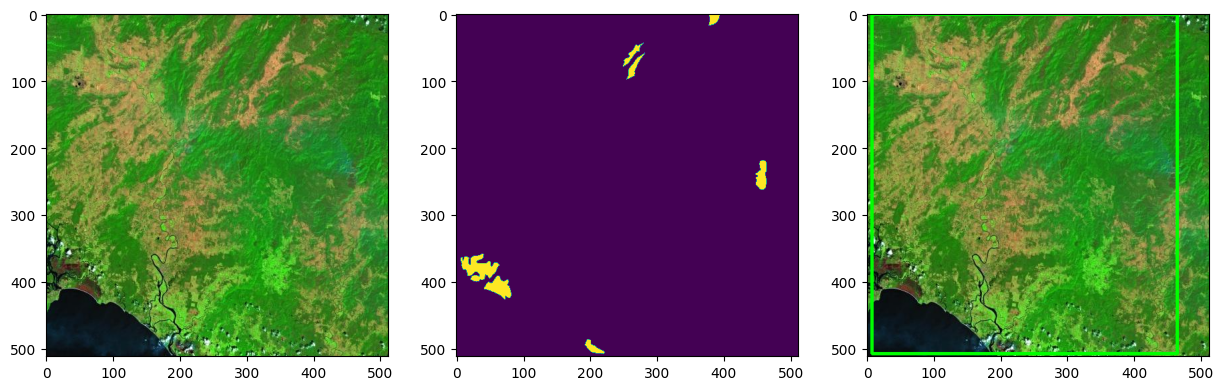

In [9]:
### READ DATA

ROOT = "/content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset"
MODEL_SAVE_PATH = "/content/drive/MyDrive/ResearchProject/models/mask_rcnn"

TRAIN_IMG_DIR = ROOT + "/images/train_images"
TRAIN_MASK_DIR = ROOT + "/masks/train_masks"
VAL_IMG_DIR = ROOT + "/images/val_images"
VAL_MASK_DIR = ROOT + "/masks/val_masks"
TEST_IMG_DIR = ROOT + '/images/test_images'
TEST_MASK_DIR = ROOT + '/masks/test_masks'

BATCH_SIZE = 16
IMG_SIZE = 512

transform = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
])


train_dataset = BurnedAreaDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform)
valid_dataset = BurnedAreaDataset(VAL_IMG_DIR, VAL_MASK_DIR, transform)
test_dataset = BurnedAreaDataset(TEST_IMG_DIR, TEST_MASK_DIR, transform)

# sanity check
random_int = random.randint(0, len(valid_dataset))
print(random_int)
sample = valid_dataset[random_int]

image = sample[0]
image = image.permute(1,2,0)

mask = sample[1]["masks"]
mask = mask.permute(1,2,0)
mask = mask.squeeze()

boxes = sample[1]["boxes"]
image_with_bb = image.numpy().copy()
for box in boxes:
    image_with_bb = cv2.rectangle(image_with_bb, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,1,0), 3)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(image_with_bb)

plt.show()

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_count(),
    collate_fn=utils.collate_fn)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_count(),
    collate_fn=utils.collate_fn)

test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_count(),
    collate_fn=utils.collate_fn)

In [10]:
### START TRAINING

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using CUDA")
else:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("using MPS")
    else:
        device = torch.device("cpu")
        print("using CPU")

num_classes = 2
model = get_model_instance_segmentation(num_classes, pre_trained=True)
load = True
if load:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH + '/best_model.pth'))
model.to(device)
IMG_SIZE = 512
summary(model, (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

using CUDA


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:00<00:00, 192MB/s]


Layer (type:depth-idx)                             Output Shape              Param #
MaskRCNN                                           [1, 4]                    --
├─GeneralizedRCNNTransform: 1-1                    [16, 3, 800, 800]         --
├─BackboneWithFPN: 1-2                             [16, 256, 13, 13]         --
│    └─IntermediateLayerGetter: 2-1                [16, 2048, 25, 25]        --
│    │    └─Conv2d: 3-1                            [16, 64, 400, 400]        (9,408)
│    │    └─BatchNorm2d: 3-2                       [16, 64, 400, 400]        (128)
│    │    └─ReLU: 3-3                              [16, 64, 400, 400]        --
│    │    └─MaxPool2d: 3-4                         [16, 64, 200, 200]        --
│    │    └─Sequential: 3-5                        [16, 256, 200, 200]       (215,808)
│    │    └─Sequential: 3-6                        [16, 512, 100, 100]       1,219,584
│    │    └─Sequential: 3-7                        [16, 1024, 50, 50]        7,098,368
│    │

In [11]:
input_tensor = torch.randn(1, 3, 512, 512).to('cuda')
flops, params = profile(model, inputs=(input_tensor,))
print(f"Flops: {flops:,}, Params: {params:,}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
Flops: 280,791,593,472.0, Params: 45,880,411.0


In [12]:
NUM_EPOCHS = 500
PATIENCE = 100
LEARNING_RATE_0 = 0.001
LEARNING_RATE_F = LEARNING_RATE_0 * 0.1
WEIGHT_DECAY = 5e-4

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LEARNING_RATE_0,
    momentum=0.9,
    weight_decay=WEIGHT_DECAY
)

lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1,
    end_factor=0.1,
    total_iters=NUM_EPOCHS
)

# train(model=model,
#       num_epochs=NUM_EPOCHS,
#       patience=PATIENCE,
#       train_dataloader=train_dataloader,
#       valid_dataloader=valid_dataloader,
#       save_path=MODEL_SAVE_PATH,
#       optimizer=optimizer,
#       scheduler=lr_scheduler,
#       device=device)

In [13]:
### VALIDATION DATASET EVALUATION
accuracy = validate_model(model, VAL_IMG_DIR, VAL_MASK_DIR, device)

100%|██████████| 288/288 [02:20<00:00,  2.05it/s]


In [19]:
for k, v in accuracy.items():
    print(k, v)

f1_score 0.7375970248822649
iou 0.8698109882707471
mcc 0.730124144911765


In [15]:
### TEST DATASET EVALUATION
accuracy = validate_model(model, TEST_IMG_DIR, TEST_MASK_DIR, device)

100%|██████████| 300/300 [02:12<00:00,  2.27it/s]


In [21]:
for k, v in accuracy.items():
    print(k, v)

f1_score 0.6125981998893896
iou 0.8849065206782198
mcc 0.611069088617031


6


  0%|          | 0/6 [00:00<?, ?it/s]

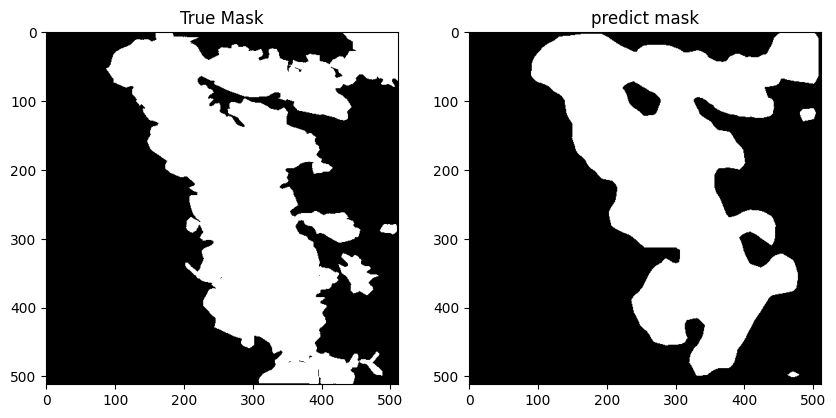

 17%|█▋        | 1/6 [00:01<00:05,  1.13s/it]

F1-score: 0.8930


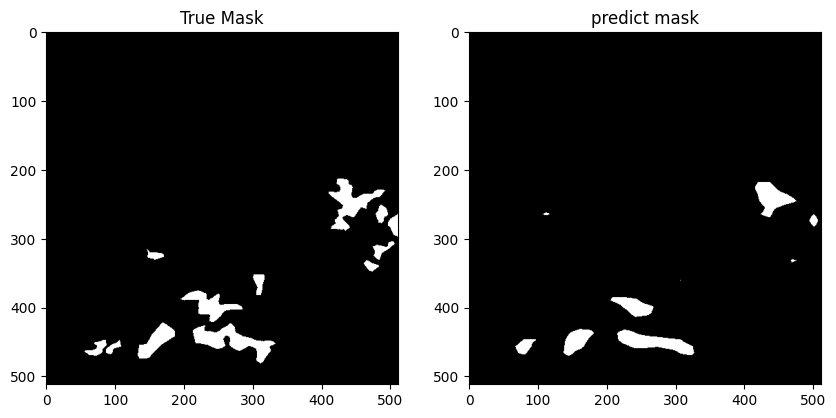

 33%|███▎      | 2/6 [00:02<00:04,  1.10s/it]

F1-score: 0.6206


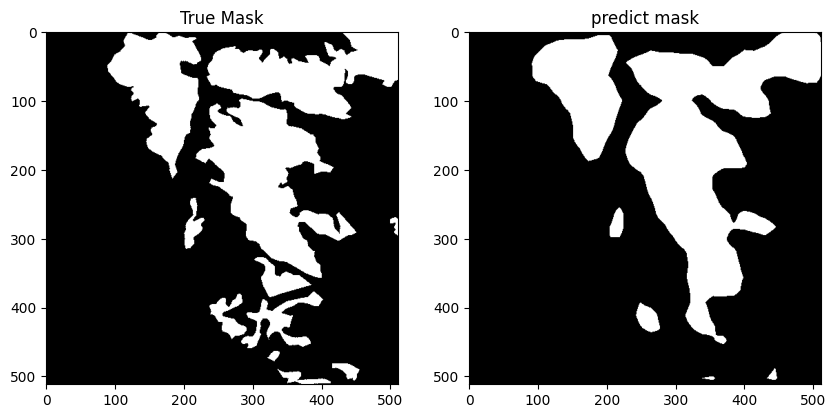

 50%|█████     | 3/6 [00:03<00:03,  1.10s/it]

F1-score: 0.8713


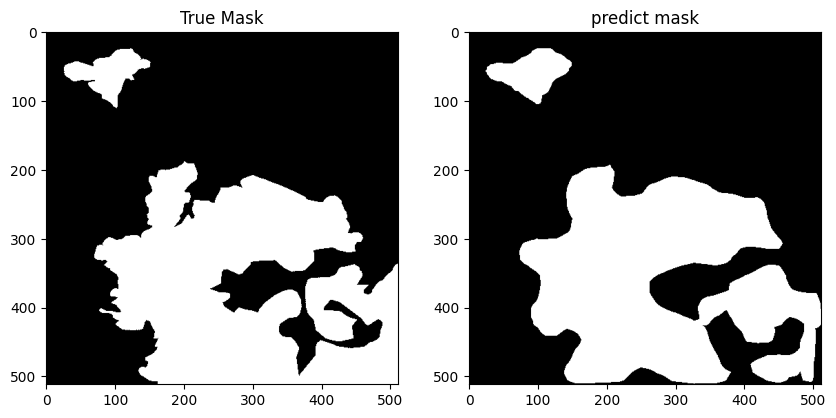

 67%|██████▋   | 4/6 [00:04<00:02,  1.10s/it]

F1-score: 0.9117


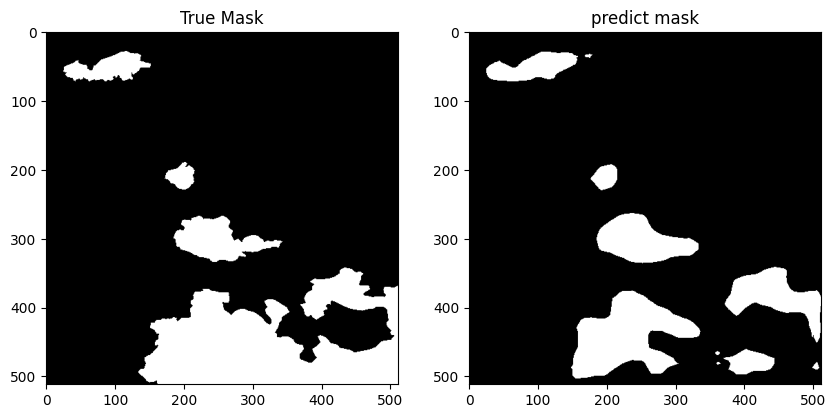

 83%|████████▎ | 5/6 [00:05<00:01,  1.10s/it]

F1-score: 0.7355


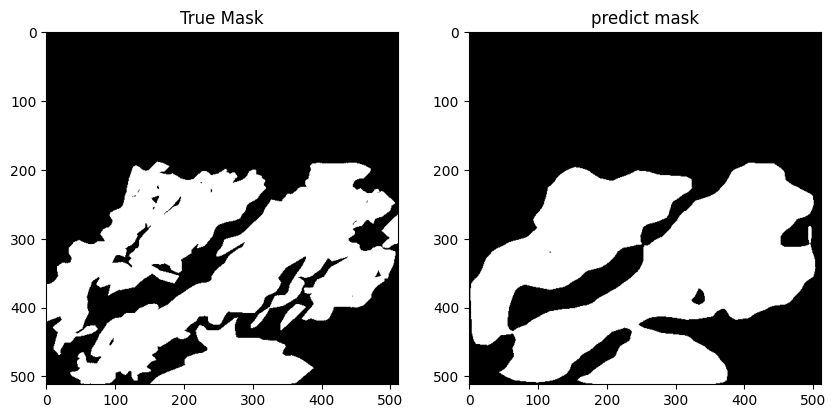

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

F1-score: 0.9129


In [17]:
### VISUALIZE SAMPLE IMAGES PREDICTIONS

VISUAL_IMG_DIR = ROOT + '/images/visual_check_images'
VISUAL_MASK_DIR = ROOT + '/masks/visual_check_masks'

imgs = list(Path(VISUAL_IMG_DIR).glob("**/*.jpeg"))
masks = list(Path(VISUAL_MASK_DIR).glob("**/*.jpeg"))

print(len(imgs))

imgs = {img.stem: img for img in imgs}
data = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]


model.eval()
model.to(device)

running_loss = 0.0

running_f1 = 0.0
running_iou = 0.0
running_mcc = 0.0

accuracy = {}

with torch.no_grad():

    for image_path, mask_path in tqdm(data):
        image_path = str(image_path)
        mask_path = str(mask_path)

        image = read_image(image_path)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype(np.uint8)

        x = F.convert_image_dtype(image, dtype=torch.float)
        x = x[:3].to(device)
        outputs = model([x])
        outputs_0 = outputs[0]

        pred_masks = (outputs_0["masks"] > 0.5).squeeze(1).byte()
        combined_pred_mask = torch.clamp(pred_masks.sum(dim=0), 0, 1).cpu()
        combined_pred_mask = combined_pred_mask.cpu().numpy()

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(mask, cmap='gray')  # True mask
        plt.title('True Mask')

        plt.subplot(1, 2, 2)
        plt.imshow(combined_pred_mask, cmap='gray')  # Predicted mask
        plt.title('predict mask')

        plt.show()

        f1_score = get_f1(mask, combined_pred_mask)
        # get acc here
        print(f"F1-score: {f1_score:.4f}")
